# Plot alignment statistics of barcode library

## Load libraries and define analysis-specific parameters

PB: We should add rasilabRtemplates to the Docker and Singularity containers. 

In [13]:
suppressMessages(library(Biostrings))
suppressMessages(library(plyranges))
suppressMessages(library(tidyverse))

## Read alignment log

In [14]:
align_log <- list.files("../data/alignments/", pattern = "*.log", full.names = T) %>% 
  enframe("sno", "file") %>% 
  mutate(log = map(file, readLines)) %>% 
  mutate(sample_name = str_extract(file, "[^/]+(?=.bowtie2.log)")) %>% 
  select(-sno, -file) %>% 
  unnest() %>% 
  print()

Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(log)`”


# A tibble: 12 × 2
   log                                             sample_name           
   <chr>                                           <chr>                 
 1 "88591225 reads; of these:"                     endo12k_grna_barcode_1
 2 "  88591225 (100.00%) were unpaired; of these:" endo12k_grna_barcode_1
 3 "    16538701 (18.67%) aligned 0 times"         endo12k_grna_barcode_1
 4 "    72048577 (81.33%) aligned exactly 1 time"  endo12k_grna_barcode_1
 5 "    3947 (0.00%) aligned >1 times"             endo12k_grna_barcode_1
 6 "81.33% overall alignment rate"                 endo12k_grna_barcode_1
 7 "66900143 reads; of these:"                     endo12k_mrna_barcode_1
 8 "  66900143 (100.00%) were unpaired; of these:" endo12k_mrna_barcode_1
 9 "    11668311 (17.44%) aligned 0 times"         endo12k_mrna_barcode_1
10 "    55228251 (82.55%) aligned exactly 1 time"  endo12k_mrna_barcode_1
11 "    3581 (0.01%) aligned >1 times"             endo12k_mrna_barcode_1
12 "82.56% overall 

##  How many total reads and reads with expected barcodes?


── Column specification ────────────────────────────────────────────────────────
cols(
  sample_name = col_character(),
  type = col_character(),
  count = col_double()
)



# A tibble: 6 × 4
  sample_name            read  type      count
  <chr>                  <chr> <chr>     <dbl>
1 endo12k_grna_barcode_1 total all    88591225
2 endo12k_grna_barcode_1 aln   unique 72048577
3 endo12k_grna_barcode_1 aln   multi      3947
4 endo12k_mrna_barcode_1 total all    66900143
5 endo12k_mrna_barcode_1 aln   unique 55228251
6 endo12k_mrna_barcode_1 aln   multi      3581


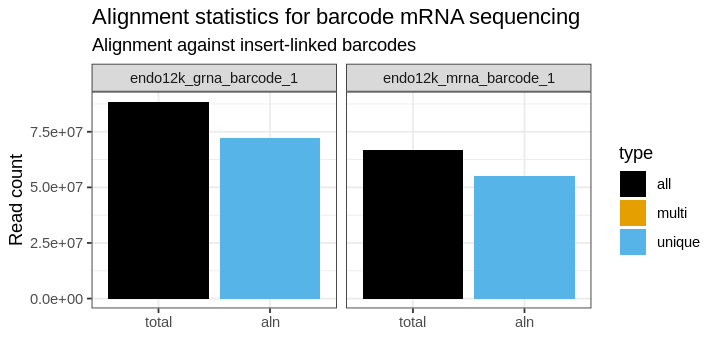

In [15]:
options(repr.plot.width=6, repr.plot.height=3)

plot_data <- align_log %>% 
  mutate(total_all = str_extract(log, "^[:digit:]+(?= reads;)")) %>% 
  mutate(aln_unique = str_extract(log, "[:digit:]+(?=.+exactly)")) %>% 
  mutate(aln_multi = str_extract(log, "[:digit:]+(?=.+>1)")) %>% 
  select(-log) %>% 
  pivot_longer(-sample_name, names_to = 'type', values_to = 'count') %>% 
  filter(!is.na(count)) %>% 
  type_convert() %>% 
  separate(type, c("read", "type")) %>% 
  print()

plot_data %>% 
  ggplot(aes(x = fct_rev(read), y = count, fill = type)) +
  facet_wrap(~sample_name, ncol = 2, scales = "free_x") +
  geom_col() +
  ggthemes::scale_fill_colorblind() +
  theme_bw() +
  labs(x = "", y = "Read count",
       title = "Alignment statistics for barcode mRNA sequencing",
       subtitle = "Alignment against insert-linked barcodes")

## Get readcounts for each barcode

In [16]:
barcode_counts <- list.files("../data/barcode_counts/", pattern = ".tsv.gz$", full.names = T) %>% 
  enframe("sno", "file") %>% 
  mutate(counts = map(file, read_tsv)) %>% 
  mutate(sample_name = str_extract(file, "[^/]+(?=.tsv.gz)")) %>% 
  select(-sno, -file) %>% 
  unnest() %>% 
  rename(barcode_count = count, barcode_num = barcode) %>% 
  mutate(sample_name = str_extract(sample_name, ".+(?=_barcode)")) %>% 
  print()

Rows: 598054 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (2): barcode, count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 641799 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (2): barcode, count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(counts)`”


# A tibble: 1,239,853 × 3
   barcode_num barcode_count sample_name 
         <dbl>         <dbl> <chr>       
 1         150          2761 endo12k_grna
 2        1844          2454 endo12k_grna
 3        3161          2317 endo12k_grna
 4         956          2273 endo12k_grna
 5        2271          2250 endo12k_grna
 6          58          2229 endo12k_grna
 7       57663          2123 endo12k_grna
 8         818          2048 endo12k_grna
 9      322867          2026 endo12k_grna
10        3293          2020 endo12k_grna
# … with 1,239,843 more rows


## Get insert-barcode linkages

In [17]:
align_log <- list.files("../data/alignments/", pattern = "*.log", full.names = T) %>% print 

insert_barcode_linkages <- list.files("../../pool3_linkage/data/filtered_barcodes/", 
                                      pattern = ".tsv.gz$", full.names = T) %>% 
  enframe("sno", "file") %>% 
  mutate(counts = map(file, read_tsv)) %>% 
  mutate(sample_name = str_extract(file, "[^/]+(?=.tsv.gz)")) %>% 
  select(-sno, -file) %>% 
  unnest(cols = c(counts)) %>%
  rename(linkage_count = read_count, linkage_ref = sample_name) %>% 
  select(-barcode_1) %>%
  print()

[1] "../data/alignments//endo12k_grna_barcode_1.bowtie2.log"
[2] "../data/alignments//endo12k_mrna_barcode_1.bowtie2.log"


Rows: 704011 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): barcode_1
dbl (3): insert_num, barcode_num, read_count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 704,011 × 4
   insert_num barcode_num linkage_count linkage_ref
        <dbl>       <dbl>         <dbl> <chr>      
 1        594           1           358 endo12k    
 2      10779           2           263 endo12k    
 3      10521           3           263 endo12k    
 4        663           4           261 endo12k    
 5       7477           5           245 endo12k    
 6       7269           6           237 endo12k    
 7       7052           7           230 endo12k    
 8       8309           8           228 endo12k    
 9       5792           9           227 endo12k    
10       9573          10           225 endo12k    
# … with 704,001 more rows


## Get sample annotations

In [18]:

sample_annotations <- read_csv("../annotations/sample_annotations.csv", comment = "#") %>% print()

Rows: 2 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): owner, sample_name, plasmid, library_type, sample_id, linkage_ref
dbl (5): barcode1_read, barcode1_start, barcode1_length, barcode1_trim5, bar...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 2 × 11
  owner sample_name  plasmid library_type sample_id barcode1_read barcode1_start
  <chr> <chr>        <chr>   <chr>        <chr>             <dbl>          <dbl>
1 pb    endo12k_grna pPBHS2… grna         139p3                 1              0
2 pb    endo12k_mrna pPBHS2… mrna         139p4                 1              0
# … with 4 more variables: barcode1_length <dbl>, linkage_ref <chr>,
#   barcode1_trim5 <dbl>, barcode1_trim3 <dbl>


## Combine barcodes counts with insert linkages

In [19]:
barcode_insert_counts <- barcode_counts %>% 
  left_join(select(sample_annotations, sample_name, linkage_ref, sample_id, library_type), by = "sample_name") %>% 
  left_join(insert_barcode_linkages, by = c("linkage_ref", "barcode_num")) %>%
  print()

# A tibble: 1,239,853 × 8
   barcode_num barcode_count sample_name  linkage_ref sample_id library_type
         <dbl>         <dbl> <chr>        <chr>       <chr>     <chr>       
 1         150          2761 endo12k_grna endo12k     139p3     grna        
 2        1844          2454 endo12k_grna endo12k     139p3     grna        
 3        3161          2317 endo12k_grna endo12k     139p3     grna        
 4         956          2273 endo12k_grna endo12k     139p3     grna        
 5        2271          2250 endo12k_grna endo12k     139p3     grna        
 6          58          2229 endo12k_grna endo12k     139p3     grna        
 7       57663          2123 endo12k_grna endo12k     139p3     grna        
 8         818          2048 endo12k_grna endo12k     139p3     grna        
 9      322867          2026 endo12k_grna endo12k     139p3     grna        
10        3293          2020 endo12k_grna endo12k     139p3     grna        
# … with 1,239,843 more rows, and 2 more variables

# Write barcode insert counts to a table for post-processing

In [20]:
barcode_insert_counts %>% 
  select(sample_id, sample_name, insert_num, barcode_num, barcode_count, linkage_count, library_type, linkage_ref) %>% 
  write_tsv('../tables/sample_insert_barcode_counts.tsv.gz') %>%
  print()

# A tibble: 1,239,853 × 8
   sample_id sample_name  insert_num barcode_num barcode_count linkage_count
   <chr>     <chr>             <dbl>       <dbl>         <dbl>         <dbl>
 1 139p3     endo12k_grna      11701         150          2761           160
 2 139p3     endo12k_grna       8488        1844          2454           111
 3 139p3     endo12k_grna       5595        3161          2317           101
 4 139p3     endo12k_grna       5919         956          2273           124
 5 139p3     endo12k_grna       5335        2271          2250           107
 6 139p3     endo12k_grna       2024          58          2229           178
 7 139p3     endo12k_grna       5704       57663          2123            49
 8 139p3     endo12k_grna       5512         818          2048           127
 9 139p3     endo12k_grna       5643      322867          2026            18
10 139p3     endo12k_grna       5481        3293          2020           100
# … with 1,239,843 more rows, and 2 more variables

## Plot the number of barcodes per library

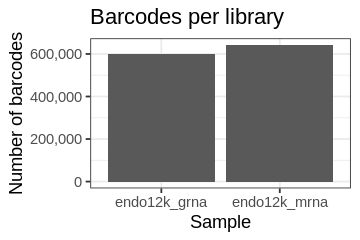

In [21]:
options(repr.plot.width=3, repr.plot.height=2)

plot_data <- barcode_insert_counts %>% 
  group_by(sample_name) %>% 
  distinct(barcode_num) %>% 
  summarize(n_barcodes = dplyr::n()) %>% 
  ungroup()

plot_data %>% 
  ggplot(aes(x = sample_name, y = n_barcodes)) +
  geom_col(position = "dodge") +
  theme_bw() +
  scale_y_continuous(labels = scales::comma) +
  # theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(x = "Sample", y = "Number of barcodes", title = "Barcodes per library") +
  NULL

## Plot CDF of the number of reads per barcode

# A tibble: 1,239,853 × 9
   barcode_num barcode_count sample_name  linkage_ref sample_id library_type
         <dbl>         <dbl> <chr>        <chr>       <chr>     <chr>       
 1       83449          3157 endo12k_mrna endo12k     139p4     mrna        
 2        1517          2860 endo12k_mrna endo12k     139p4     mrna        
 3         150          2761 endo12k_grna endo12k     139p3     grna        
 4      498043          2580 endo12k_mrna endo12k     139p4     mrna        
 5       32873          2558 endo12k_mrna endo12k     139p4     mrna        
 6        1844          2454 endo12k_grna endo12k     139p3     grna        
 7       15907          2358 endo12k_mrna endo12k     139p4     mrna        
 8      307239          2343 endo12k_mrna endo12k     139p4     mrna        
 9      568220          2329 endo12k_mrna endo12k     139p4     mrna        
10        3161          2317 endo12k_grna endo12k     139p3     grna        
# … with 1,239,843 more rows, and 3 more variables

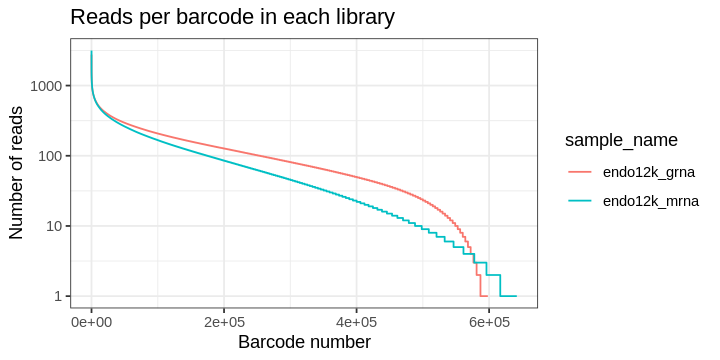

In [22]:
options(repr.plot.width=6, repr.plot.height=3)

plot_data <- barcode_insert_counts %>% 
  group_by(sample_name) %>% 
  arrange(-barcode_count) %>% 
  mutate(xaxis = 1:(dplyr::n())) %>% 
  ungroup() %>% 
  print()

plot_data %>% 
  ggplot(aes(x = xaxis, y = barcode_count, color = sample_name)) +
  geom_line(aes(group = sample_name)) +
  theme_bw() +
  scale_y_log10() +
  labs(x = "Barcode number", y = "Number of reads",
       title = "Reads per barcode in each library") +
  NULL

## Plot CDF of the number of reads per insert, summed over barcodes

`summarise()` has grouped output by 'sample_name'. You can override using the `.groups` argument.


# A tibble: 23,974 × 4
   sample_name  insert_num read_count xaxis
   <chr>             <dbl>      <dbl> <int>
 1 endo12k_grna       5772      41989     1
 2 endo12k_grna       5906      41918     2
 3 endo12k_grna       5595      38381     3
 4 endo12k_grna       5743      38064     4
 5 endo12k_grna       5823      37988     5
 6 endo12k_grna       5679      37688     6
 7 endo12k_grna       5884      36678     7
 8 endo12k_grna       5809      36243     8
 9 endo12k_grna       5887      34996     9
10 endo12k_grna       5963      34298    10
# … with 23,964 more rows


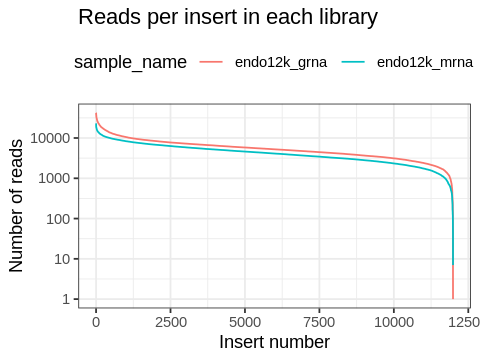

In [23]:
options(repr.plot.width=4, repr.plot.height=3)

plot_data <- barcode_insert_counts %>% 
  group_by(sample_name, insert_num) %>% 
  summarize(read_count = sum(barcode_count)) %>% 
  ungroup() %>% 
  group_by(sample_name) %>% 
  arrange(-read_count) %>% 
  mutate(xaxis = 1:(dplyr::n())) %>% 
  ungroup() %>% 
  print()

plot_data %>% 
  ggplot(aes(x = xaxis, y = read_count, color = sample_name)) +
  geom_line(aes(group = sample_name)) +
  theme_bw() +
  theme(legend.position = "top") +
  scale_y_log10() +
  labs(x = "Insert number", y = "Number of reads",
       title = "Reads per insert in each library") +
  NULL

## Plot read counts of mRNA vs gRNA, summed for each insert


`summarise()` has grouped output by 'library_type'. You can override using the `.groups` argument.


# A tibble: 11,987 × 3
   insert_num  grna  mrna
        <dbl> <dbl> <dbl>
 1          0  6594  4792
 2          1  4707  7136
 3          2  3221  3096
 4          3  6824  4946
 5          4  7380  7472
 6          5  2459  1590
 7          6  4197  3593
 8          7  5466  3228
 9          8  5768  3358
10          9  4108  2889
# … with 11,977 more rows


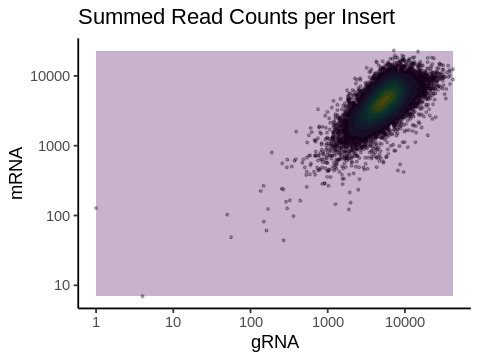

In [24]:
plot_data <- barcode_insert_counts %>% 
  group_by(library_type, insert_num) %>%
  summarize(read_count = sum(barcode_count)) %>%
  ungroup() %>%
  select(insert_num, read_count, library_type) %>%
  pivot_wider(names_from = "library_type", values_from = "read_count") %>%
  print()

plot_data %>%
  filter(!is.na(grna), !is.na(mrna)) %>%
  ggplot(aes(x = grna, y = mrna)) +
  geom_point(alpha = 0.3, size = 0.5) +
  geom_density_2d_filled(alpha = 0.3, show.legend = F) +
  theme_classic() +
  scale_x_log10() +
  scale_y_log10() +
  labs(x = "gRNA", y = "mRNA",
       title = "Summed Read Counts per Insert") +
  NULL